In [14]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable, Union, Literal
from scipy.stats import entropy
import desbordante as db
import itertools
from tqdm import tqdm #usually this library slow down loops


df = pd.read_csv('datasets/dft-road-casualty-statistics-vehicle-2024.csv')
df.replace({-1:np.nan, '-1':np.nan},inplace=True)

/tmp/ipykernel_190908/3295236285.py:12: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datasets/dft-road-casualty-statistics-vehicle-2024.csv')


In [15]:
def looping_col(func:Callable, df:pd.DataFrame=df, chart:bool = False) -> pd.DataFrame:
    "I don t want to see too many for loops later"
    if not chart:
        output = {col: func(df,col) for col in df.columns}
        return pd.DataFrame(output)
    else:
        for col in df.columns:
            func(df,col)


def heatmap_corr(df: pd.DataFrame) -> None:
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', annot=False,
                linewidths=0.5, square=True,
                cbar_kws={"shrink": .8})
    plt.title("Correlation Heatmap", fontsize=14, pad=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('charts/heatmap.png')
    # plt.show()

def histogram(df:pd.DataFrame,
              col:str,
              bins:Union[int, str, Literal["auto", "sturges"]]= "Sturges") -> None:
    
    s = df[col]

    if str(s.dtype) == 'object':
        return None
    
    if isinstance(bins,str) and bins.lower() == 'sturges':
        n_bins = min([round(1+np.log2(len(s))),s.nunique()]) # sturges' Rule
    elif isinstance(bins,int) or isinstance(bins,str):
        n_bins = bins
        
    try:
        plt.figure(figsize=(10, 8))
        sns.histplot(df[col].dropna(), bins=n_bins, color='skyblue', edgecolor='black')
        plt.title(f"Histogram of {col}", fontsize=14)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(f'charts/hist_{col}')
        # plt.show()
    except ValueError as e:
        raise ValueError(f"Issue in col: {col}") from e 


# to write something about NA values, that here there arent but it different context we should take them into consideration when computing uniqueness etc
def summary_df(df:pd.DataFrame, col:str) -> int:
    s = df[col]
    #i explicit dropna=True
    Q25 = Q50 = Q75 = lower = upper = out_count = out_pct = None

    # let s get the wiskers
    if np.issubdtype(s.dtype, np.number):
        Q25 = s.quantile(0.25)
        Q50 = s.quantile(0.5)
        Q75 = s.quantile(0.75)
        IQR = Q75 - Q25
        lower = Q25 - 1.5*IQR
        upper = Q75 + 1.5*IQR
        outliers = s[(s < lower) | (s > upper)]
        out_count = outliers.count()
        out_pct = outliers.count() / s.count() * 100 

    stats = {
        "count": s.count(),
        "missing": s.isna().sum(),
        "missing_pct": s.isna().mean()*100,
        "nunique": s.nunique(dropna=True),
        'uniqueness_ratio': s.nunique(dropna=True)/len(s),
        "dtype": str(s.dtype),
        'most_freq': s.value_counts(ascending=False, dropna=True).index[0],
        '%_most_freq': round((s.value_counts(ascending=False, dropna=True).iloc[0]/s.count())*100,2),
        'entropy': entropy(s.dropna().value_counts(normalize=True)),
        "Q25": Q25,
        "Q50": Q50,
        "Q75": Q75,
        "upper_wisker": upper,
        "lower_wisker": lower,
        "outlier_count": out_count,
        "outlier_pct": out_pct
    }

    return stats

def FDs_discovery(df:pd.DataFrame,max_size:int = None):
    data = {'Col_1':[],
            'Col_2': [],
            'AFD':[]}
    
    if not max_size:
        max_size = len(df.columns)

    for size in range(2, max_size + 1):
        print(f"\nChecking FDs with {size} columns:")
        for l in itertools.permutations(df.columns,size):
            sub = df[list(l)].dropna().copy()
            A = sub[list(l[0:size-1])].drop_duplicates().shape[0]
            AB = sub.drop_duplicates().shape[0]
            sim = A/AB

            data['Col_1'].append(l[0:size-1])
            data['Col_2'].append(l[-1])
            data['AFD'].append(sim)
            if sim==1.0:
                print(f'Exact FD: {l[0:size-1]} -> {l[-1]} :: AFD sim. of {A/AB}')
            elif sim>=0.99:
                print(f'Approx FD: {l[0:size-1]} -> {l[-1]} :: AFD sim. of {A/AB}')
    print('Done FDs Discovery')
    return pd.DataFrame(data)


def unique_col_comb(df:pd.DataFrame, max_size: int = None):
    
    if not max_size: 
        max_size = len(df.columns)

    non_unique = []
    output = []
    for size in range(2, max_size+1):
        print(f'Finding combinations of {size} columns:\n')
        for cols in itertools.combinations(df.columns, size):

            # we shall check the Minimal Uniqueness to reduce computation time
            if any(st.issubset(set(cols)) for st in non_unique):
                continue
            sub = df[list(cols)].dropna().copy()
            unique = sub.duplicated().sum() == 0
            output.append({"Columns": cols, "unique": unique})

            if not unique:
                non_unique.append(set(cols)) # if set it s easy to cross check
    print('Done UCC')
    return pd.DataFrame(output)



In [16]:
print(f'The dataset has: {df.shape[0]} rows and {df.shape[1]} columns')

print('\nGet overall description:')

df.describe(include='all')

The dataset has: 183514 rows and 32 columns

Get overall description:


,collision_index,collision_year,collision_ref_no,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre_historic,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,...,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,lsoa_of_driver,escooter_flag,driver_distance_banding
count,183514,183514.0,183514,183514.000000,182154.000000,181138.000000,72953.000000,177932.000000,178017.000000,177979.000000,...,154892.000000,154892.000000,129117.000000,133050.000000,133072.000000,131065,142998.000000,137383,183514.000000,142998.000000
unique,100927,NaN,100927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,729,NaN,33463,NaN,NaN
top,2024471416027,NaN,471416027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,FORD FIESTA,NaN,E01019456,NaN,NaN
freq,26,NaN,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4700,NaN,313,NaN,NaN
mean,NaN,2024.0,NaN,1.550863,10.095754,0.272522,29.155936,20.386254,4.479482,4.506475,...,41.449688,6.989580,1761.613157,2.012131,8.910725,NaN,5.106421,NaN,0.007204,1.993657
std,NaN,0.0,NaN,2.497009,11.391285,1.486411,34.389356,24.025175,2.684757,2.671115,...,17.038257,1.851655,1574.886438,1.928146,6.014178,NaN,2.775711,NaN,0.084569,1.242110
min,NaN,2024.0,NaN,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,25.000000,1.000000,0.000000,NaN,1.000000,NaN,0.000000,1.000000
25%,NaN,2024.0,NaN,1.000000,9.000000,0.000000,9.000000,9.000000,2.000000,2.000000,...,28.000000,6.000000,1200.000000,1.000000,4.000000,NaN,3.000000,NaN,0.000000,1.000000
50%,NaN,2024.0,NaN,1.000000,9.000000,0.000000,18.000000,19.000000,5.000000,5.000000,...,39.000000,7.000000,1560.000000,1.000000,8.000000,NaN,5.000000,NaN,0.000000,1.000000
75%,NaN,2024.0,NaN,2.000000,9.000000,0.000000,18.000000,19.000000,7.000000,7.000000,...,53.000000,8.000000,1969.000000,2.000000,13.000000,NaN,7.000000,NaN,0.000000,3.000000


In [17]:
df.vehicle_reference.value_counts(normalize=False)

vehicle_reference
1      100850
2       70940
3        8763
4        2006
5         556
6         198
7          78
8          32
9          22
10         19
11         10
13          5
12          5
14          3
16          3
15          3
19          2
20          2
17          2
18          2
25          1
162         1
964         1
112         1
22          1
161         1
23          1
24          1
32          1
203         1
21          1
26          1
111         1
Name: count, dtype: int64

In [18]:
# Homemade summary
looping_col(summary_df)

,collision_index,collision_year,collision_ref_no,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre_historic,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,...,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,lsoa_of_driver,escooter_flag,driver_distance_banding
count,183514,183514,183514,183514,182154,181138,72953,177932,178017,177979,...,154892,154892,129117,133050,133072,131065,142998,137383,183514,142998
missing,0,0,0,0,1360,2376,110561,5582,5497,5535,...,28622,28622,54397,50464,50442,52449,40516,46131,0,40516
missing_pct,0.0,0.0,0.0,0.0,0.741088,1.294724,60.24663,3.04173,2.995412,3.016119,...,15.59663,15.59663,29.64188,27.498719,27.486731,28.580381,22.07788,25.137592,0.0,22.07788
nunique,100927,1,100927,33,21,7,19,18,10,10,...,99,11,948,8,77,729,10,33463,2,5
uniqueness_ratio,0.549969,0.000005,0.549969,0.00018,0.000114,0.000038,0.000104,0.000098,0.000054,0.000054,...,0.000539,0.00006,0.005166,0.000044,0.00042,0.003972,0.000054,0.182346,0.000011,0.000027
dtype,object,int64,object,int64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,object,float64,object,int64,float64
most_freq,2024471416027,2024,471416027,1,9.0,0.0,18.0,19.0,1.0,1.0,...,30.0,6.0,1598.0,1.0,1.0,FORD FIESTA,2.0,E01019456,0,1.0
%_most_freq,0.01,100.0,0.01,54.95,69.04,96.05,39.67,52.03,15.72,15.15,...,2.86,22.73,6.58,52.83,6.83,3.59,11.73,0.23,99.28,52.56
entropy,11.455337,0.0,11.455337,0.925805,1.303119,0.205693,2.082618,1.852732,2.232761,2.236242,...,4.169469,2.002793,4.588359,1.036205,3.092513,5.501029,2.291068,10.224104,0.042715,1.300503
Q25,None,2024.0,None,1.0,9.0,0.0,9.0,9.0,2.0,2.0,...,28.0,6.0,1200.0,1.0,4.0,None,3.0,None,0.0,1.0


In [19]:
# quick check on the collision_index, as apparently there are duplicates 
# -> prob due to multiple cars involved in the same accident
df.collision_index.value_counts(ascending=False)

collision_index
2024471416027    26
2024461393694    20
2024543395024    16
2024201532611    13
2024461401096    13
                 ..
2024332400746     1
2024451529872     1
2024471442399     1
2024501475486     1
2024221530823     1
Name: count, Length: 100927, dtype: int64

In [20]:
ucc = unique_col_comb(df,max_size=4)
fds = FDs_discovery(df,max_size=3)

Finding combinations of 2 columns:

Finding combinations of 3 columns:

Finding combinations of 4 columns:

Done UCC

Checking FDs with 2 columns:
Exact FD: ('collision_index',) -> collision_year :: AFD sim. of 1.0
Exact FD: ('collision_index',) -> collision_ref_no :: AFD sim. of 1.0
Approx FD: ('collision_index',) -> escooter_flag :: AFD sim. of 0.9901987716578694
Exact FD: ('collision_ref_no',) -> collision_index :: AFD sim. of 1.0
Exact FD: ('collision_ref_no',) -> collision_year :: AFD sim. of 1.0
Approx FD: ('collision_ref_no',) -> escooter_flag :: AFD sim. of 0.9901987716578694
Exact FD: ('vehicle_reference',) -> collision_year :: AFD sim. of 1.0
Exact FD: ('vehicle_type',) -> collision_year :: AFD sim. of 1.0
Exact FD: ('vehicle_type',) -> escooter_flag :: AFD sim. of 1.0
Exact FD: ('towing_and_articulation',) -> collision_year :: AFD sim. of 1.0
Exact FD: ('vehicle_manoeuvre_historic',) -> collision_year :: AFD sim. of 1.0
Exact FD: ('vehicle_manoeuvre_historic',) -> vehicle_ma

In [21]:

with pd.ExcelWriter('outputs/task_1.xlsx') as W:
    ucc.to_excel(W, sheet_name="ucc")
    fds.to_excel(W, sheet_name="fds")  

In [22]:
# get sample output of FDs
fds[fds.AFD>=0.99].head(10)

,Col_1,Col_2,AFD
0,"(collision_index,)",collision_year,1.000000
1,"(collision_index,)",collision_ref_no,1.000000
29,"(collision_index,)",escooter_flag,0.990199
62,"(collision_ref_no,)",collision_index,1.000000
63,"(collision_ref_no,)",collision_year,1.000000
91,"(collision_ref_no,)",escooter_flag,0.990199
94,"(vehicle_reference,)",collision_year,1.000000
125,"(vehicle_type,)",collision_year,1.000000
153,"(vehicle_type,)",escooter_flag,1.000000
156,"(towing_and_articulation,)",collision_year,1.000000


In [23]:
# get sample output of Unique Column Combinations
ucc[ucc.unique==True].head(10)

,Columns,unique
2,"(collision_index, vehicle_reference)",True
61,"(collision_ref_no, vehicle_reference)",True


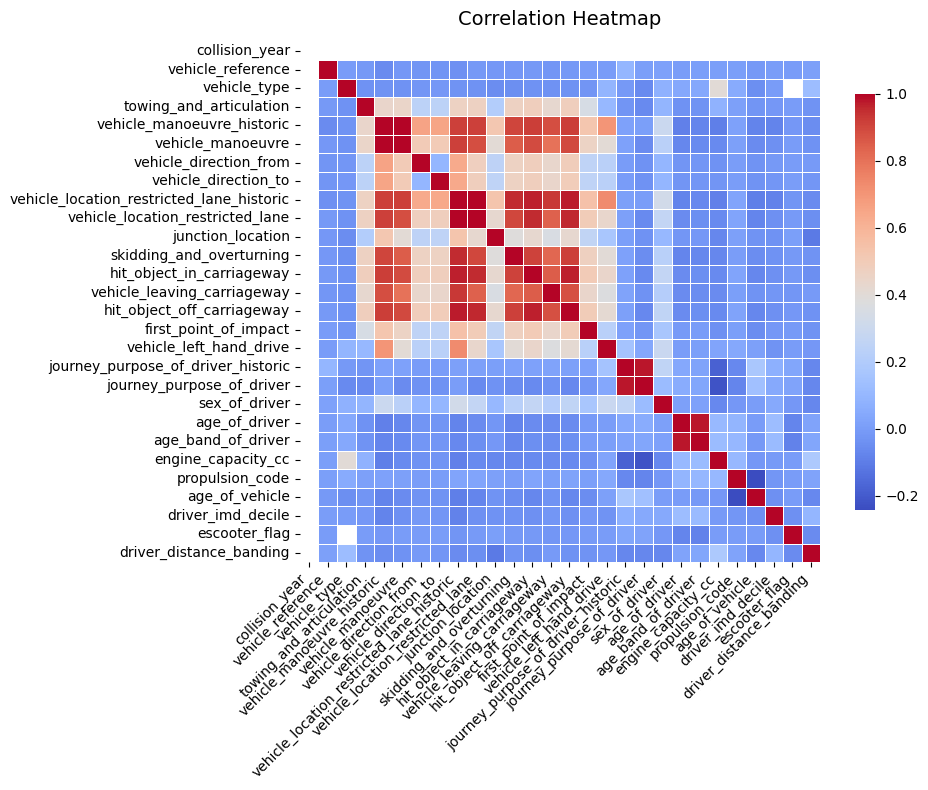

In [24]:
heatmap_corr(df)

/tmp/ipykernel_190908/4130826762.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))


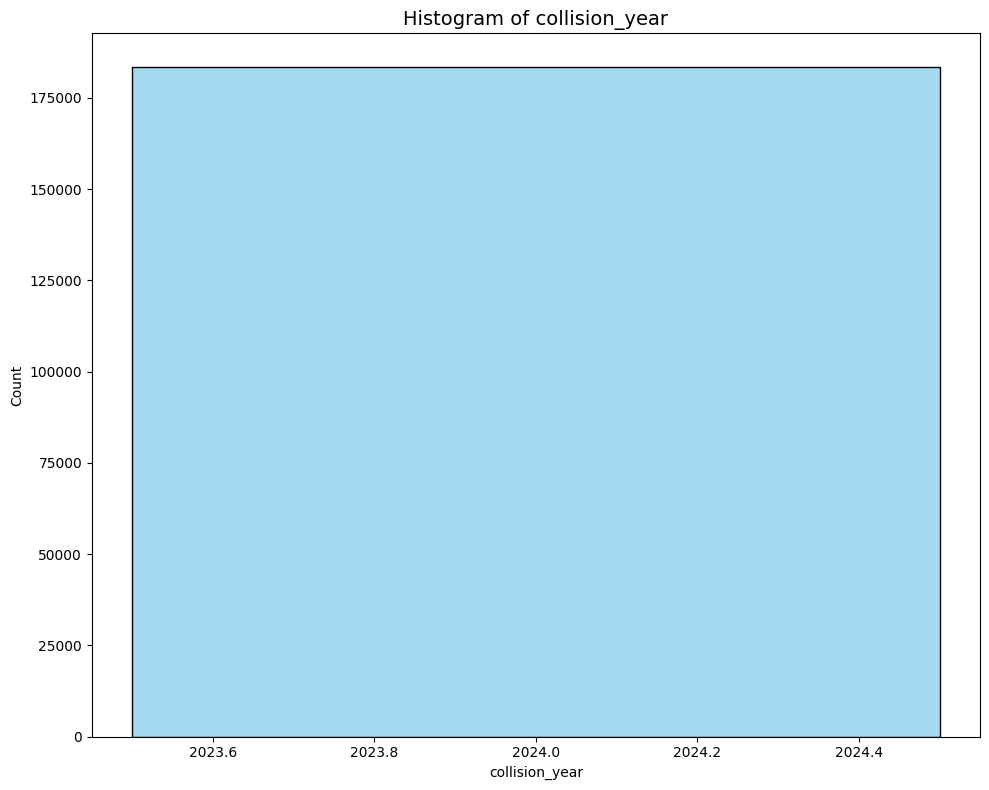

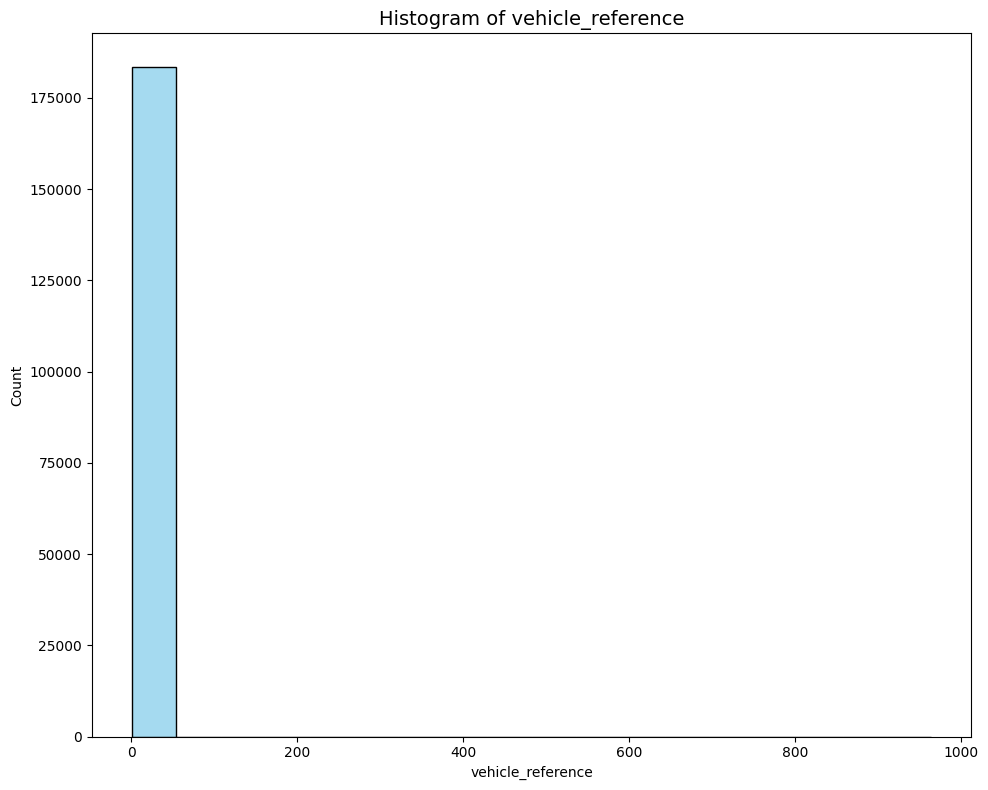

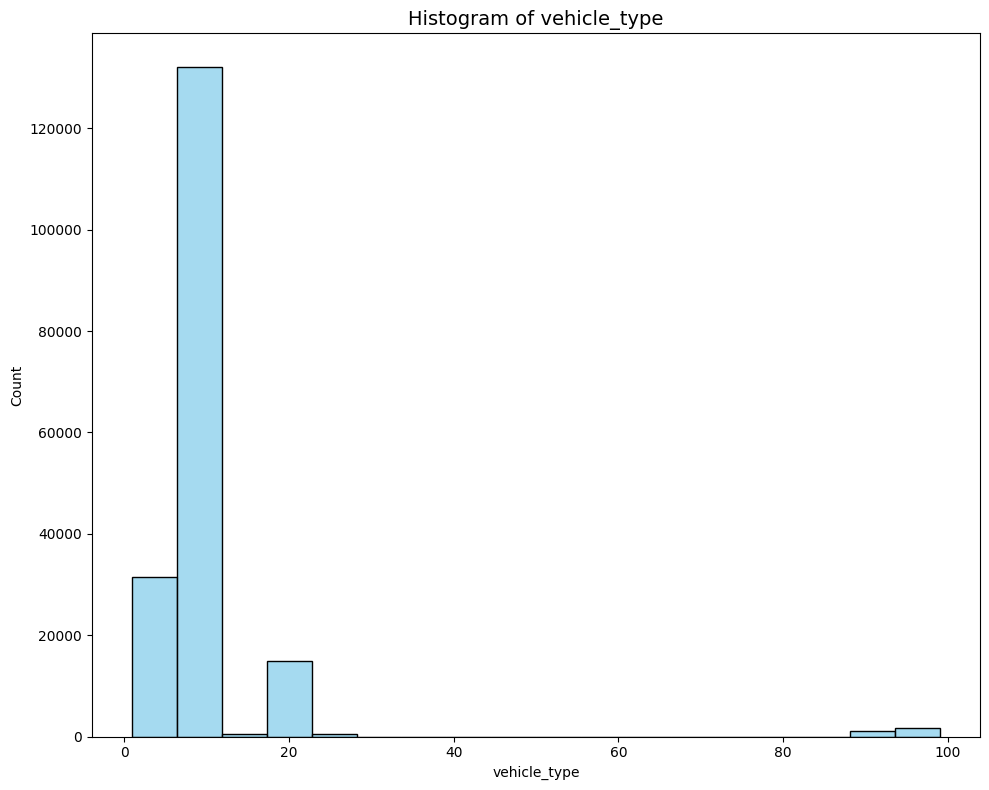

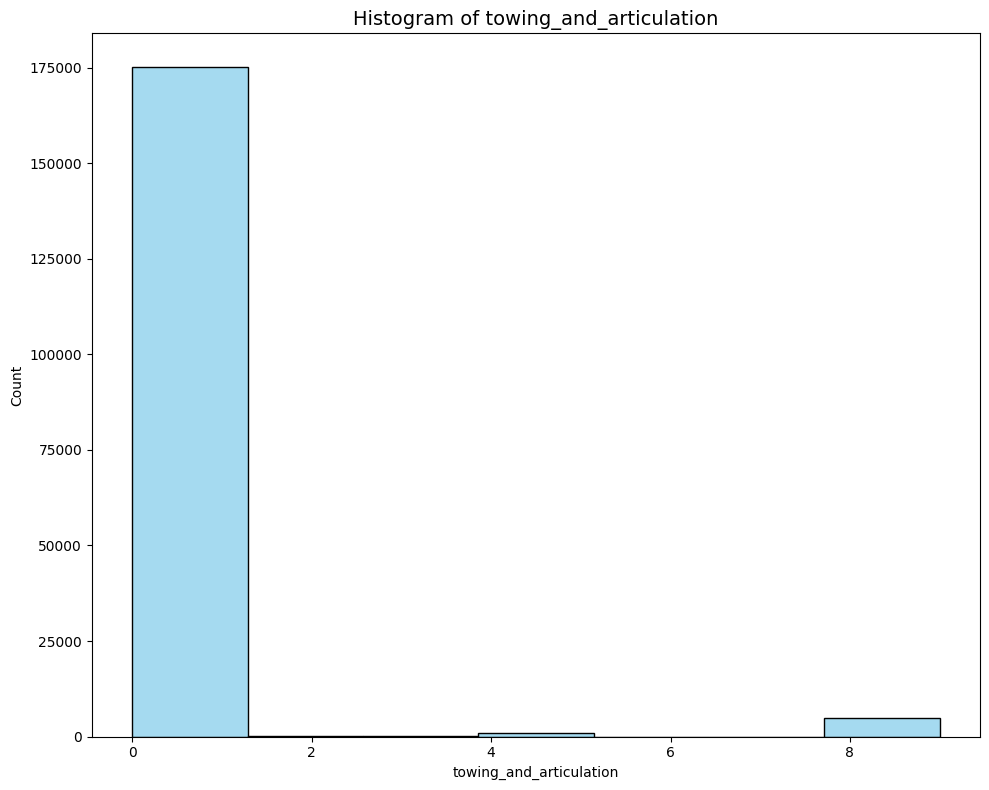

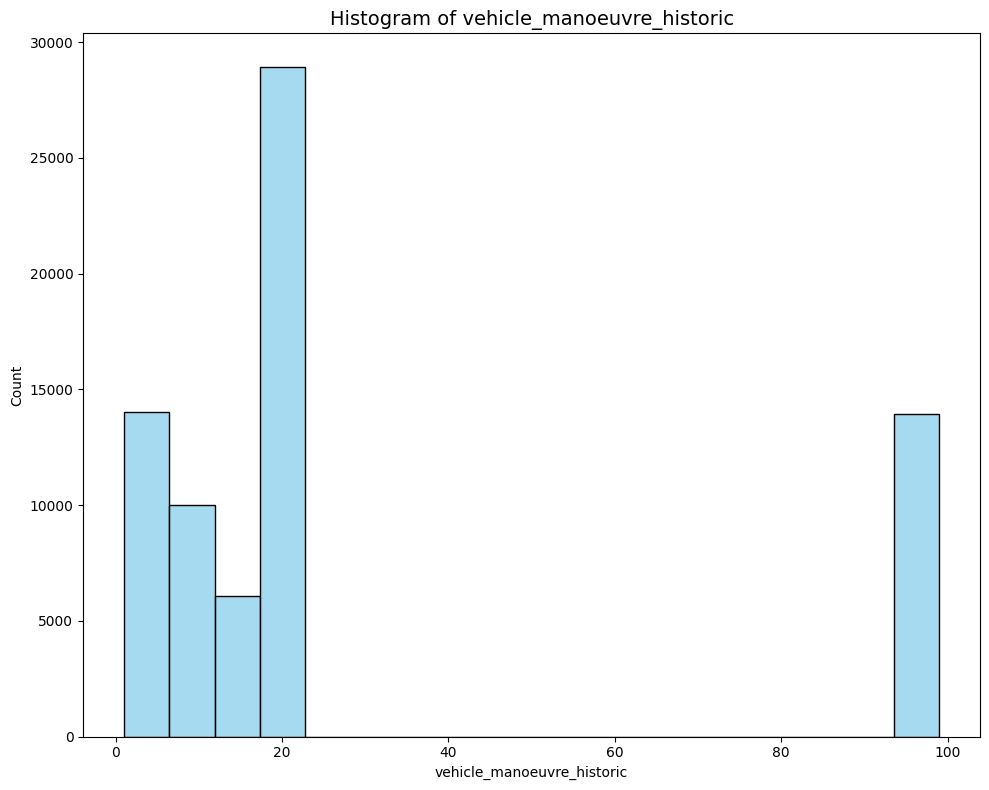

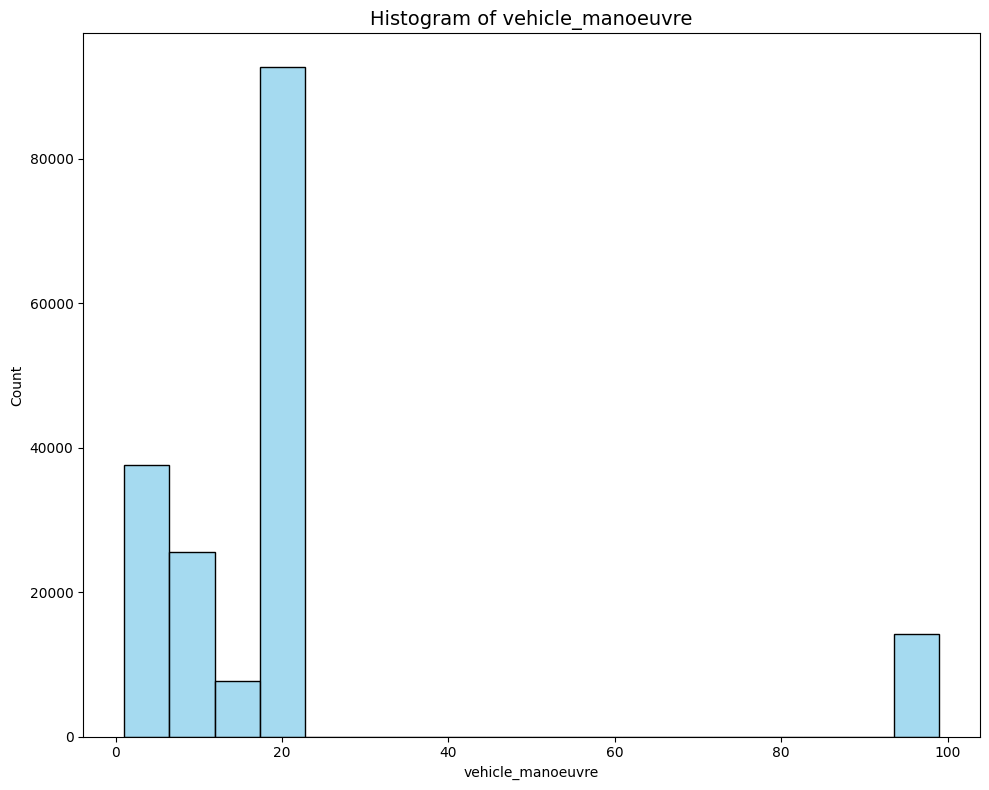

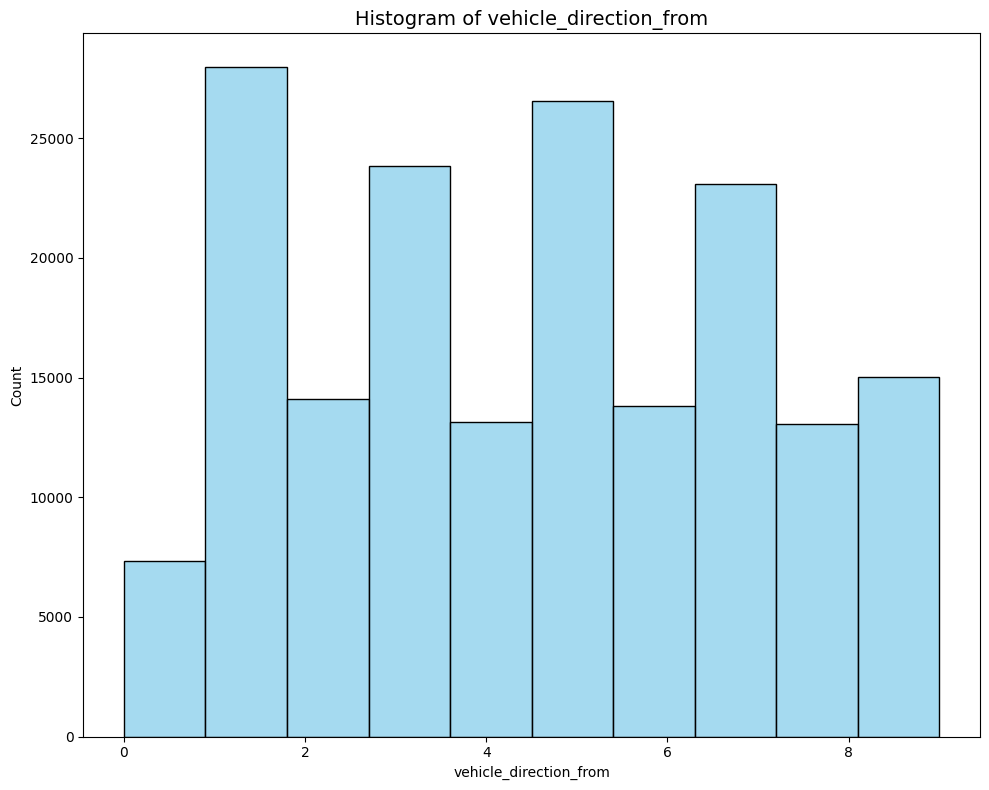

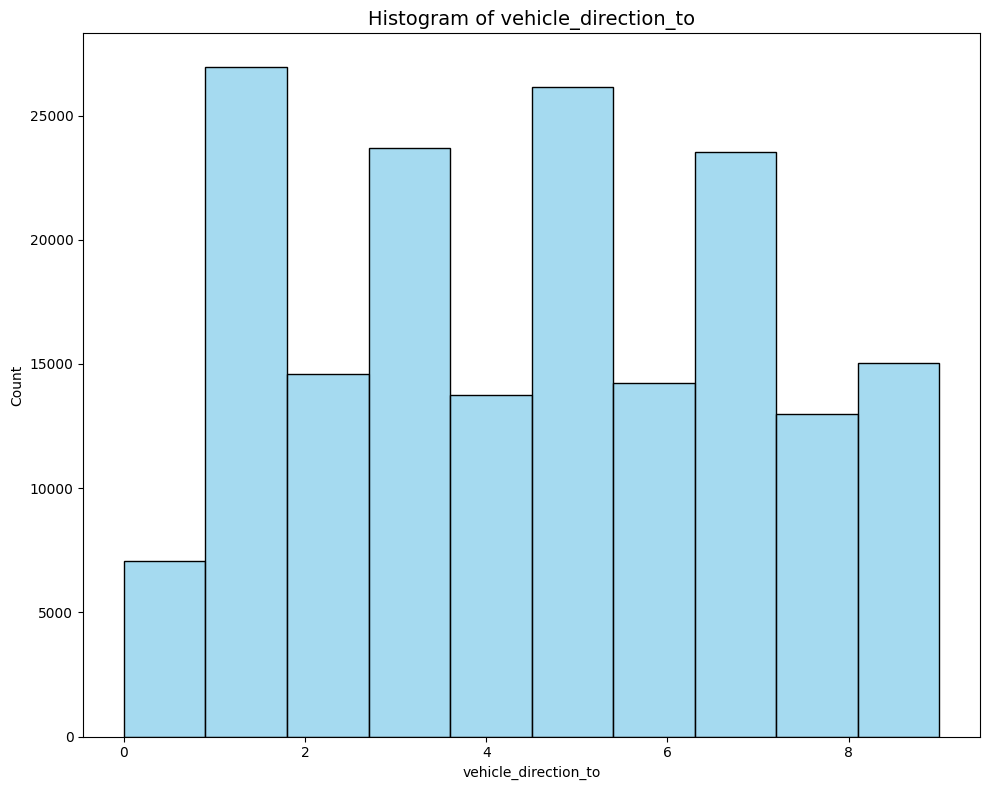

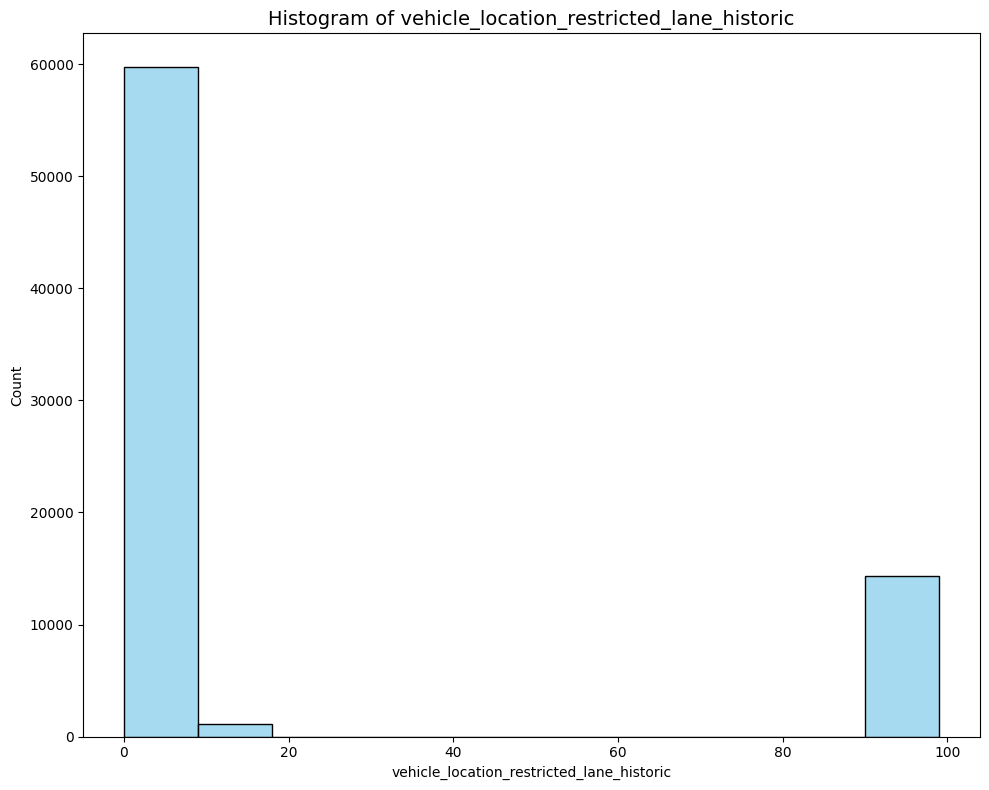

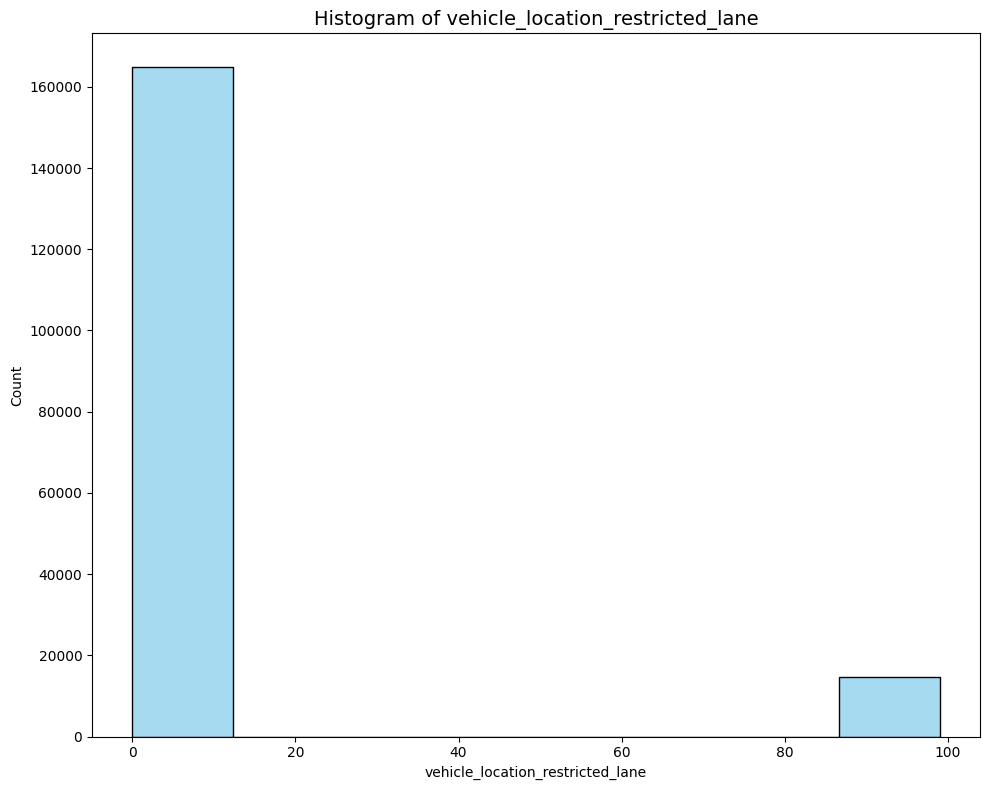

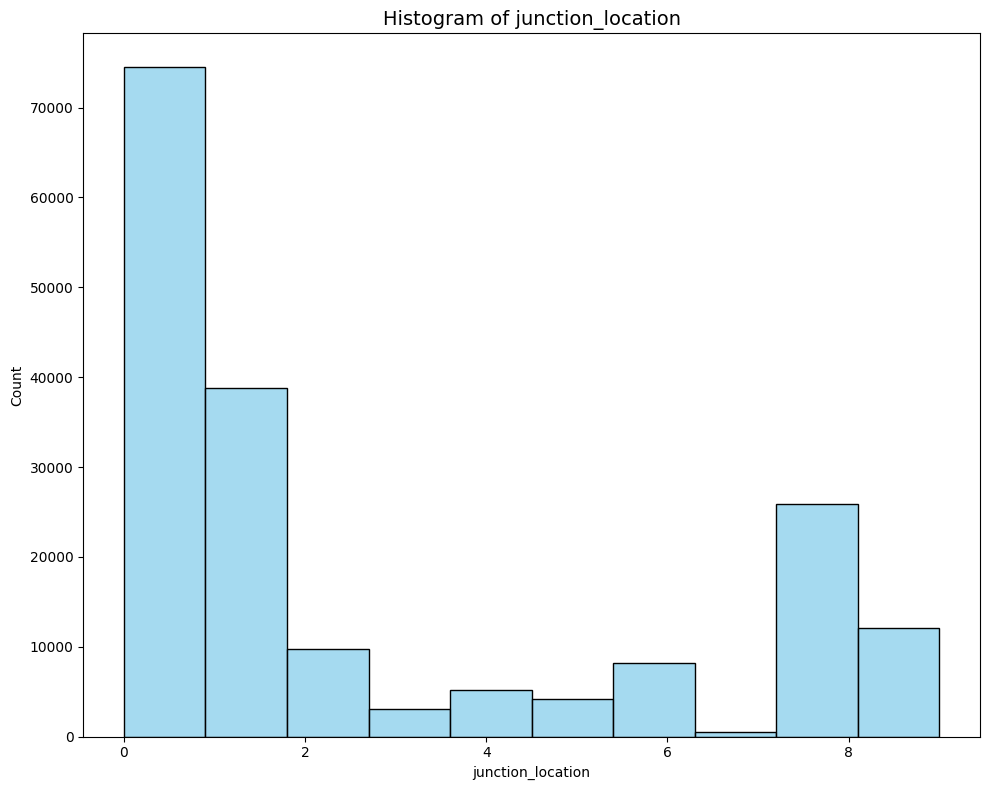

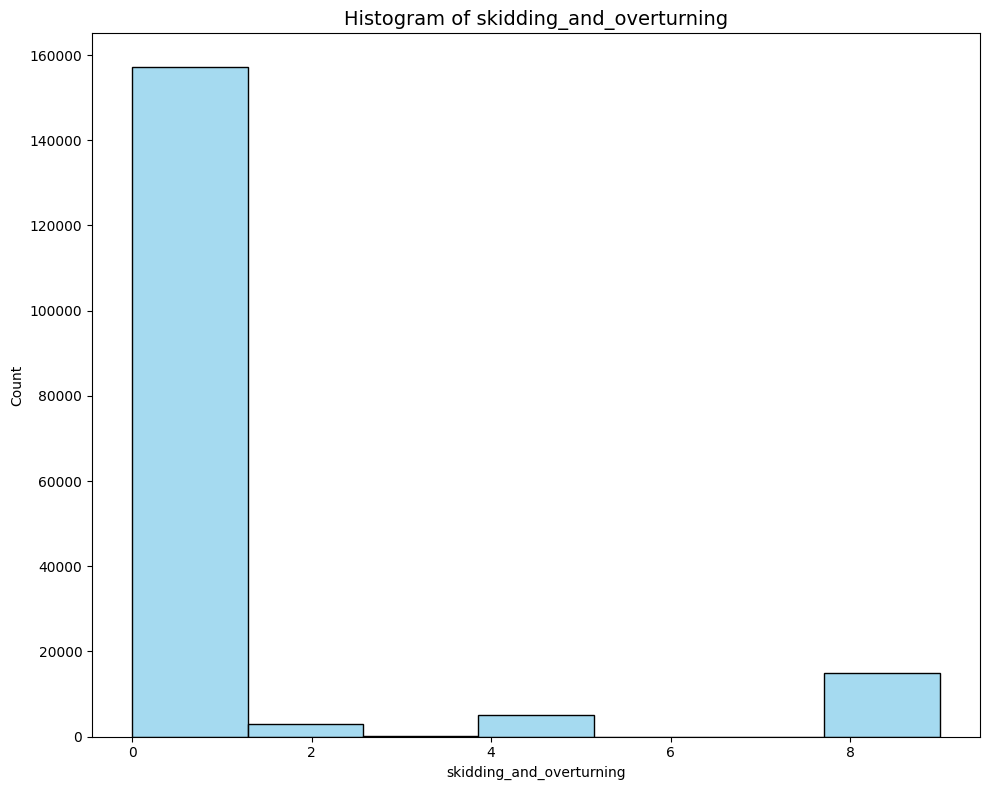

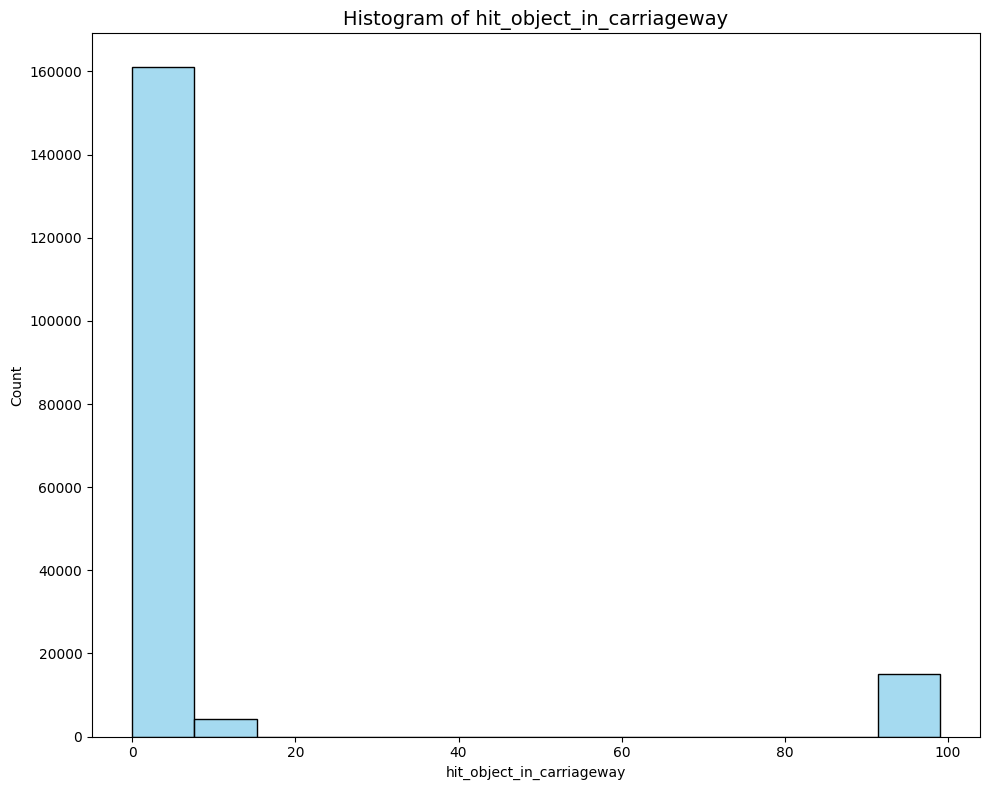

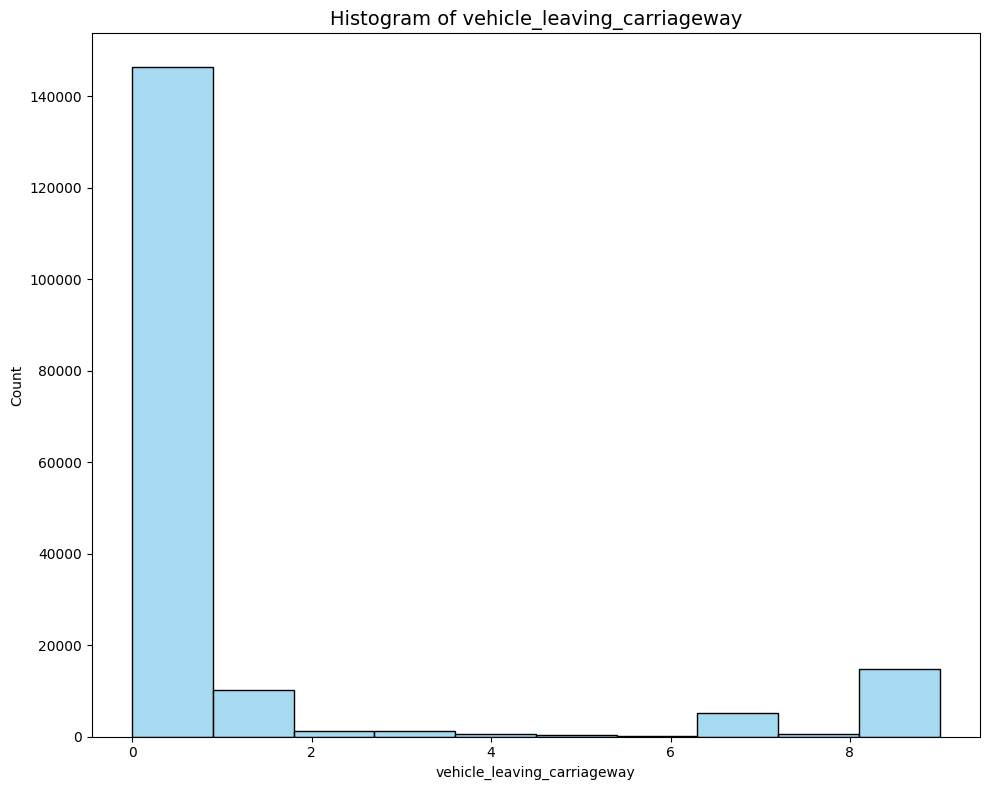

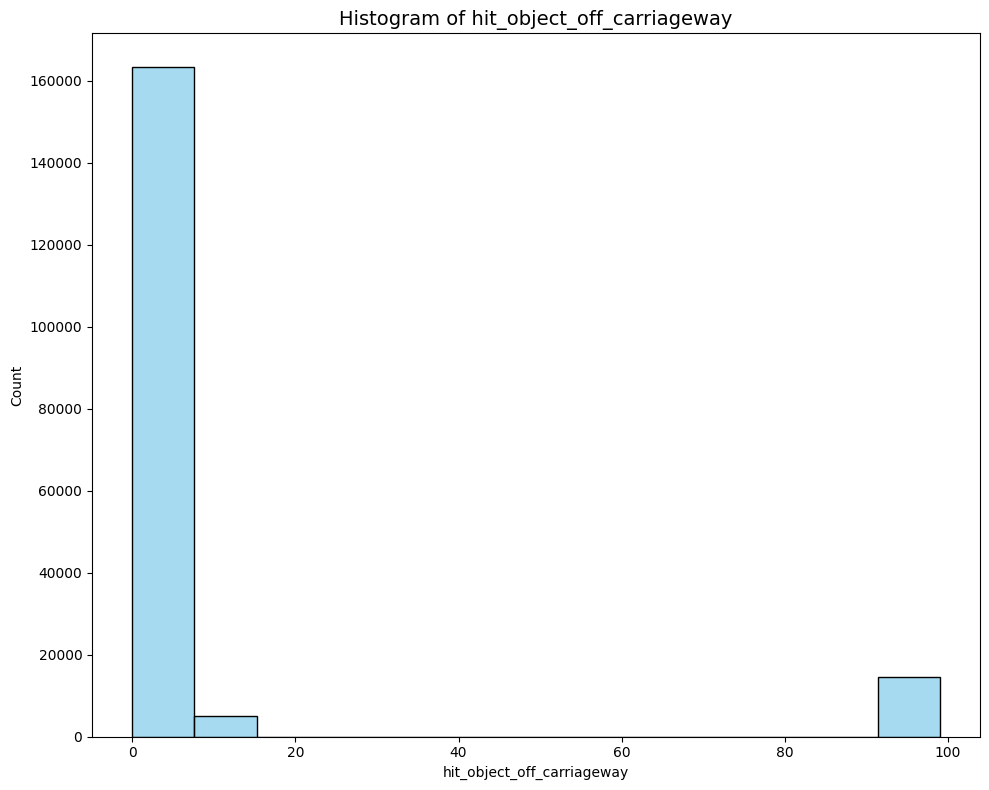

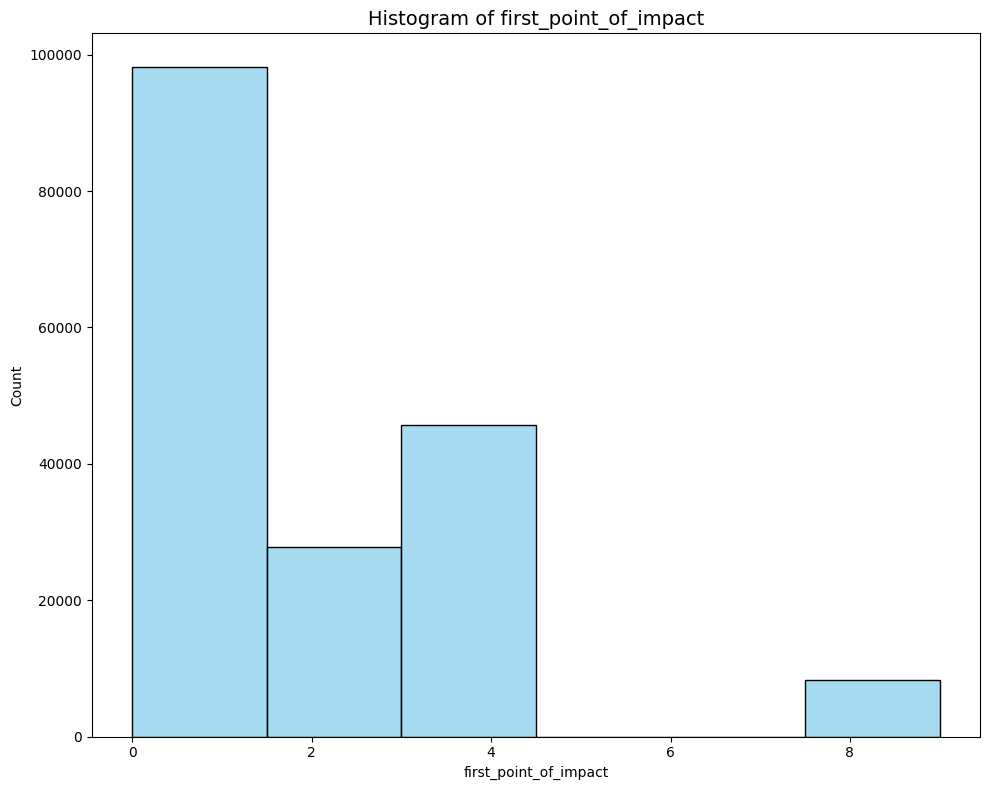

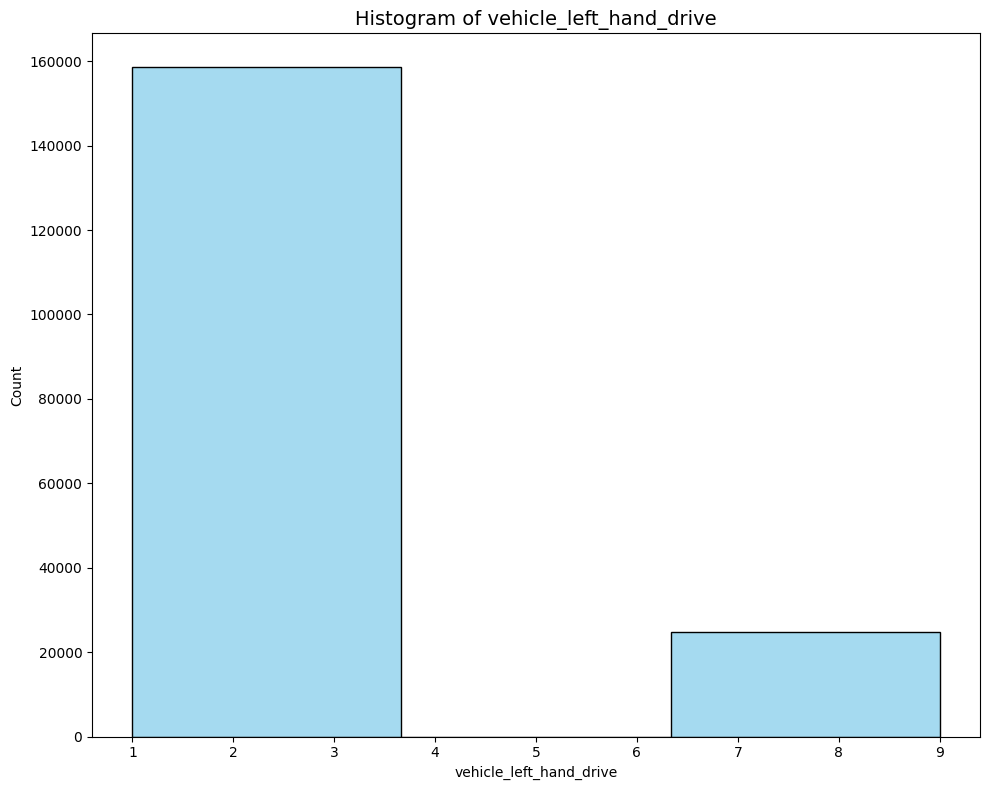

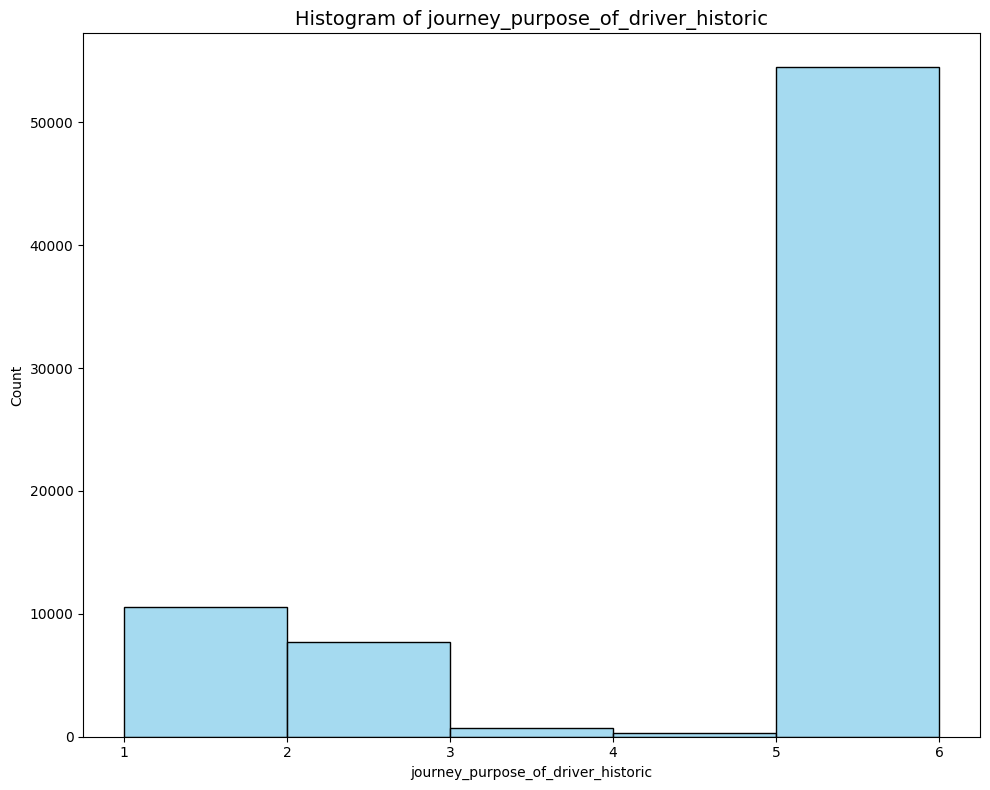

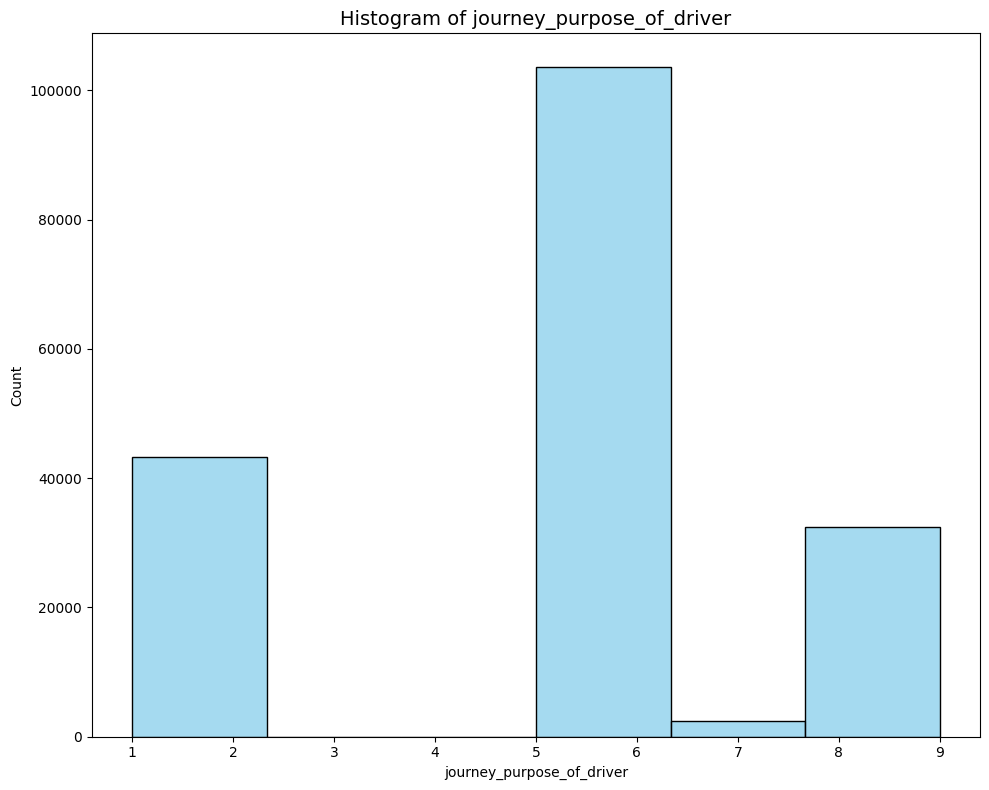

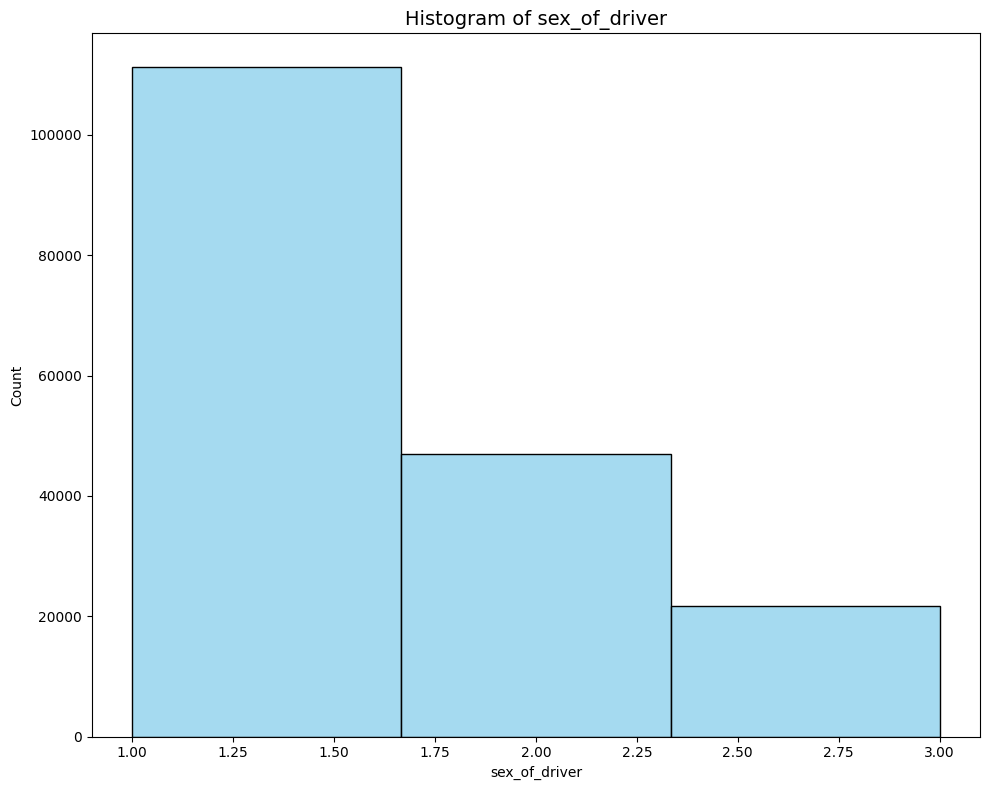

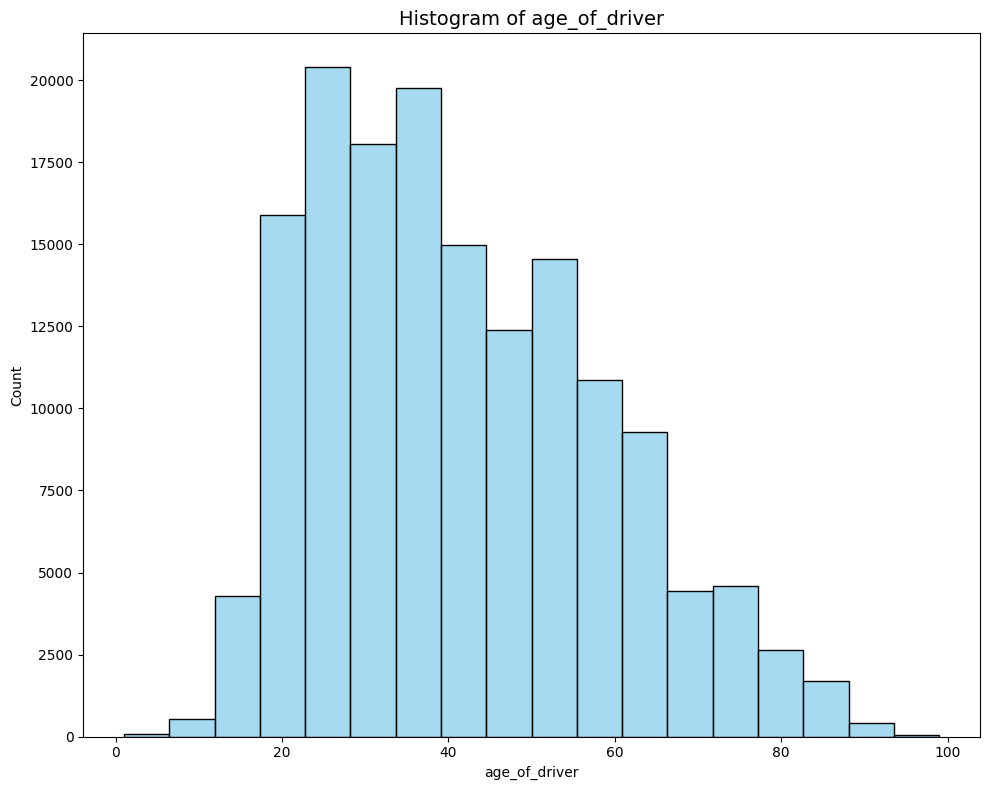

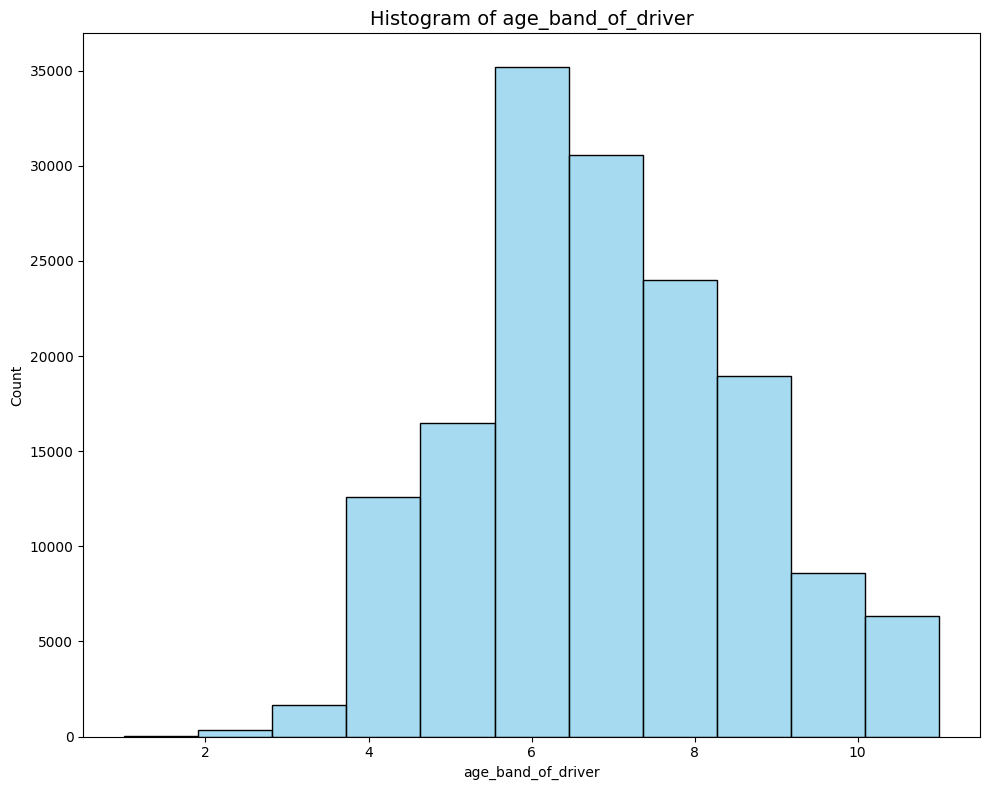

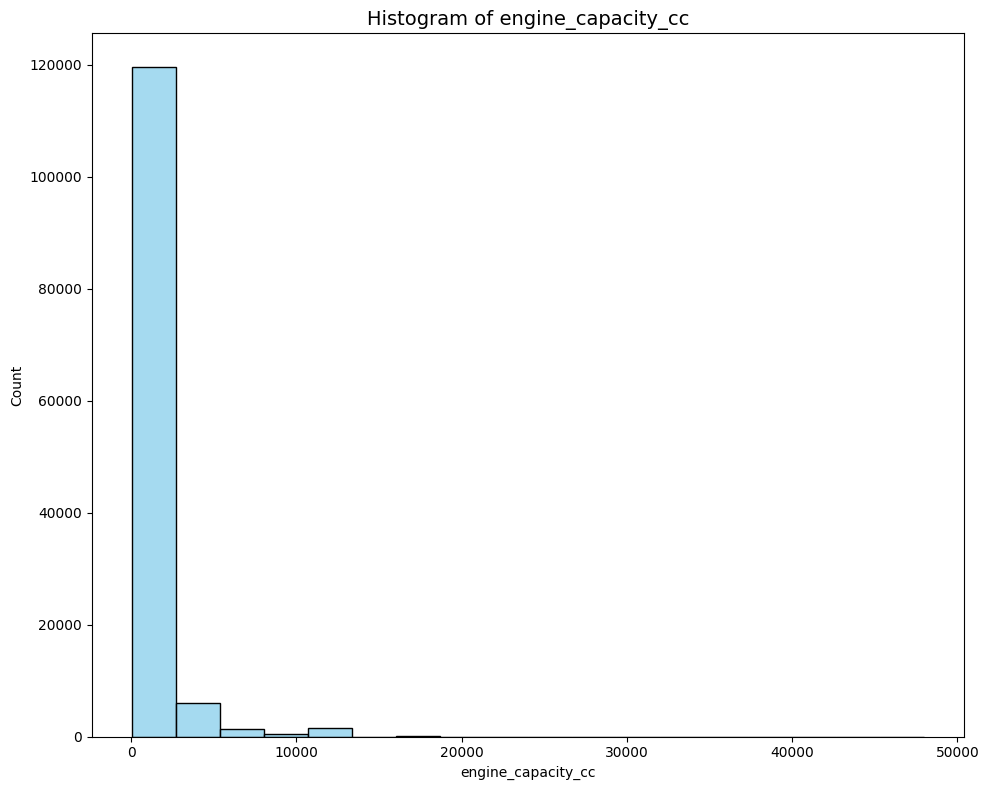

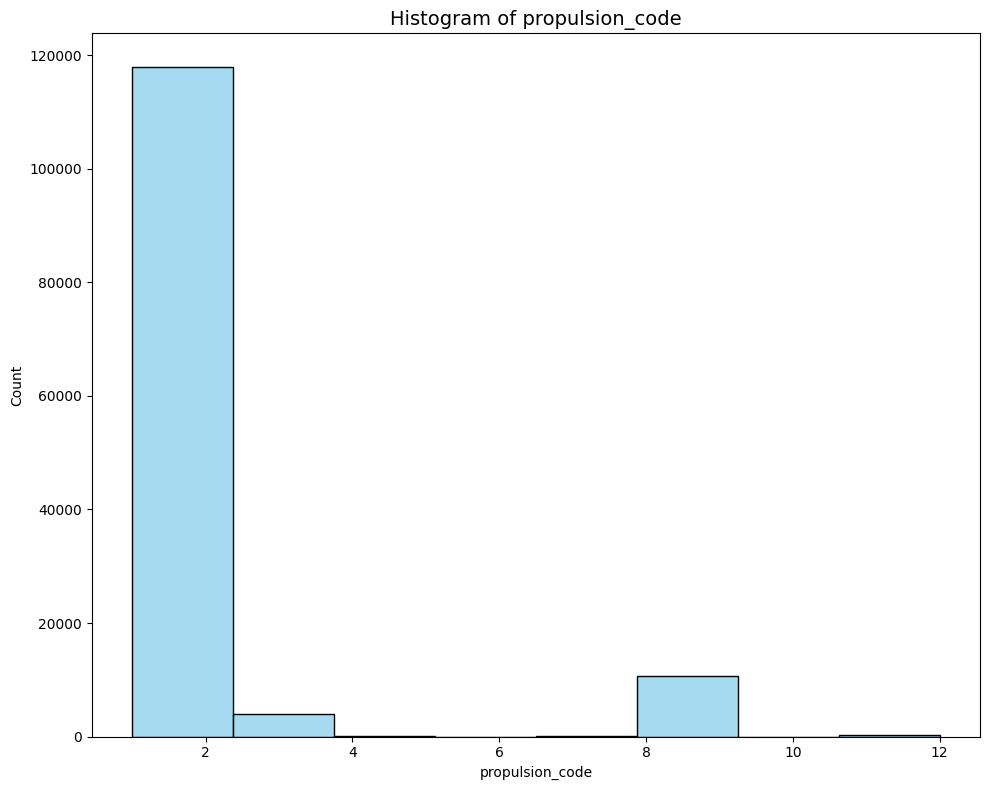

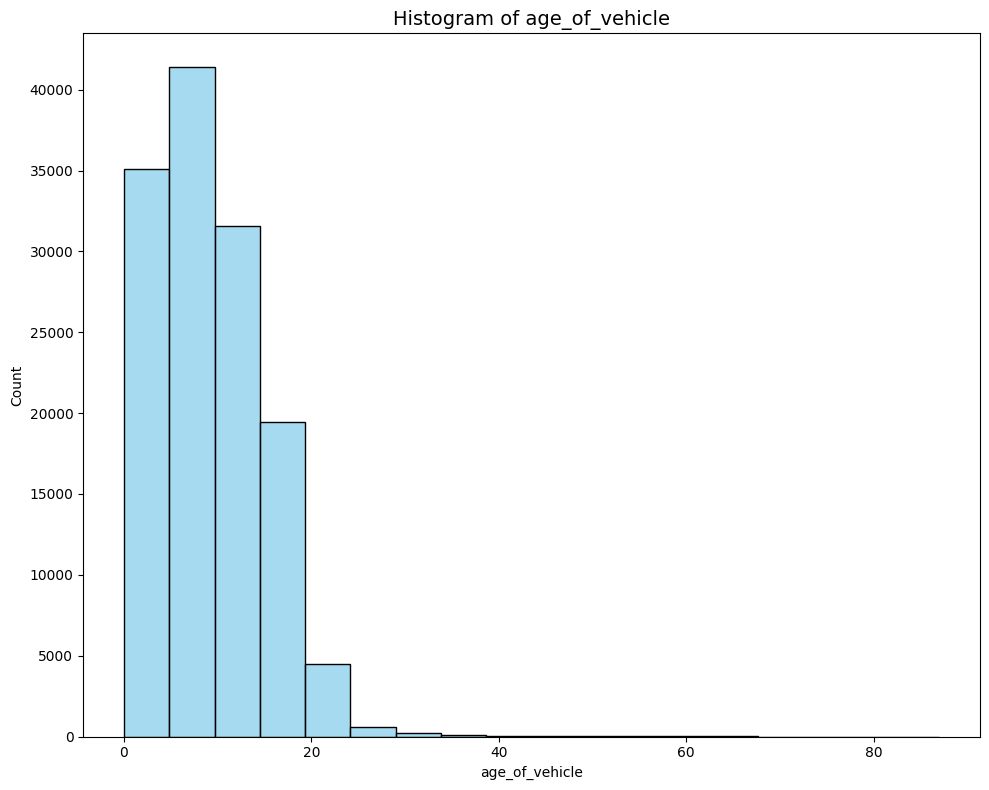

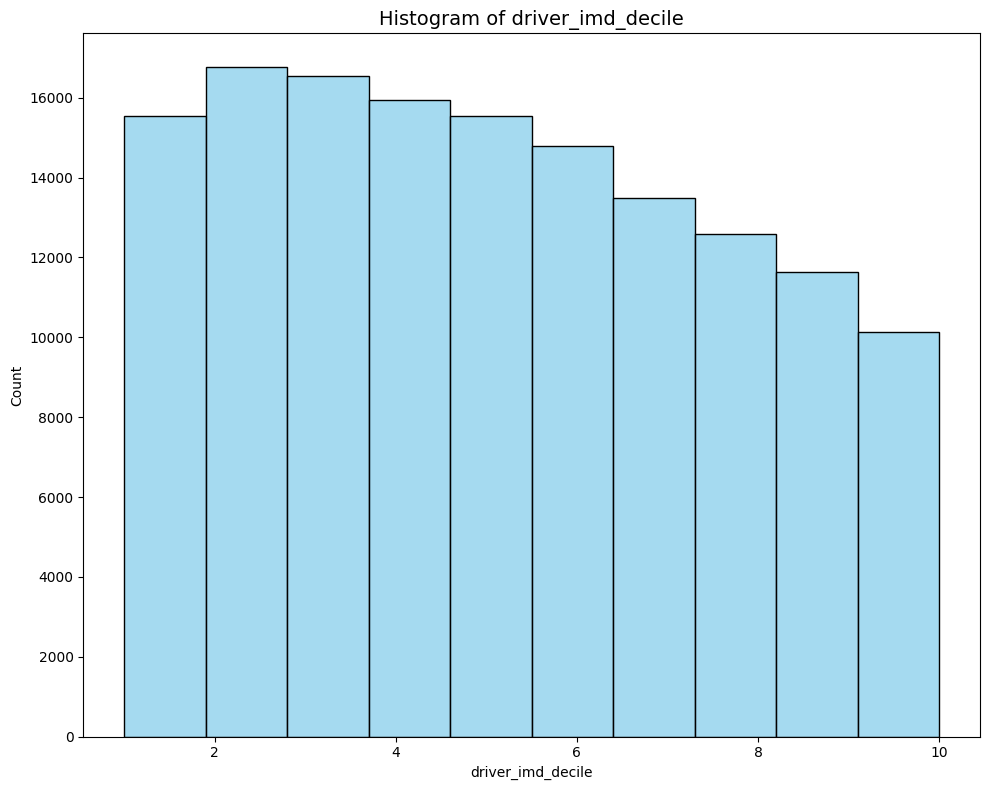

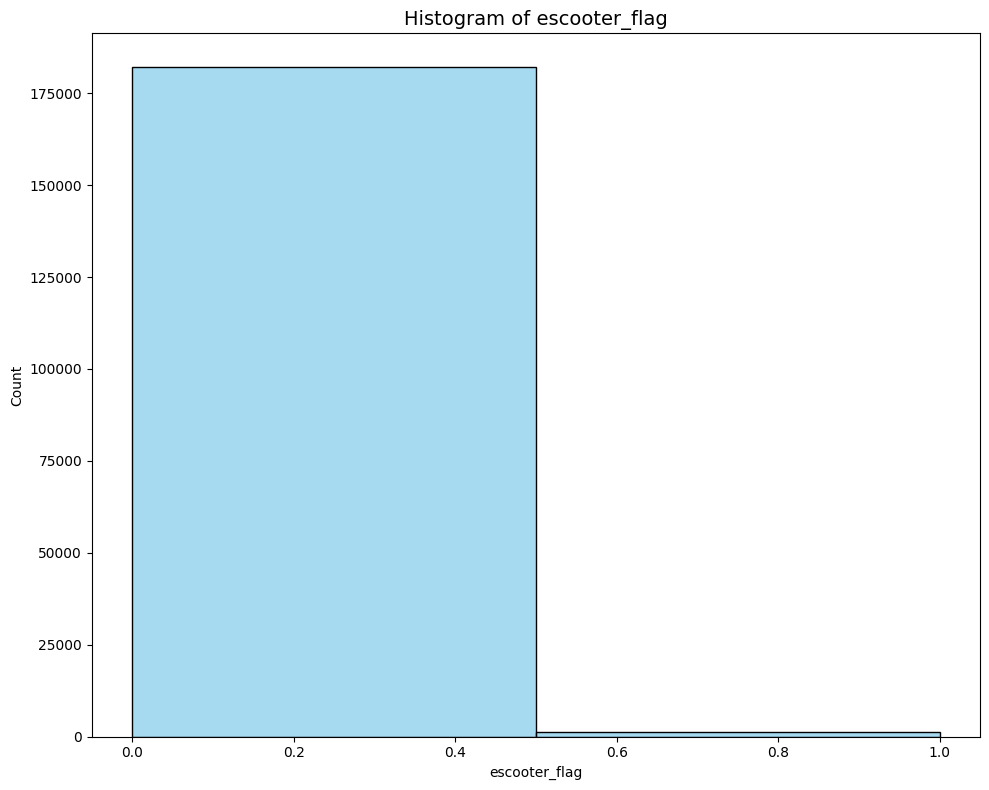

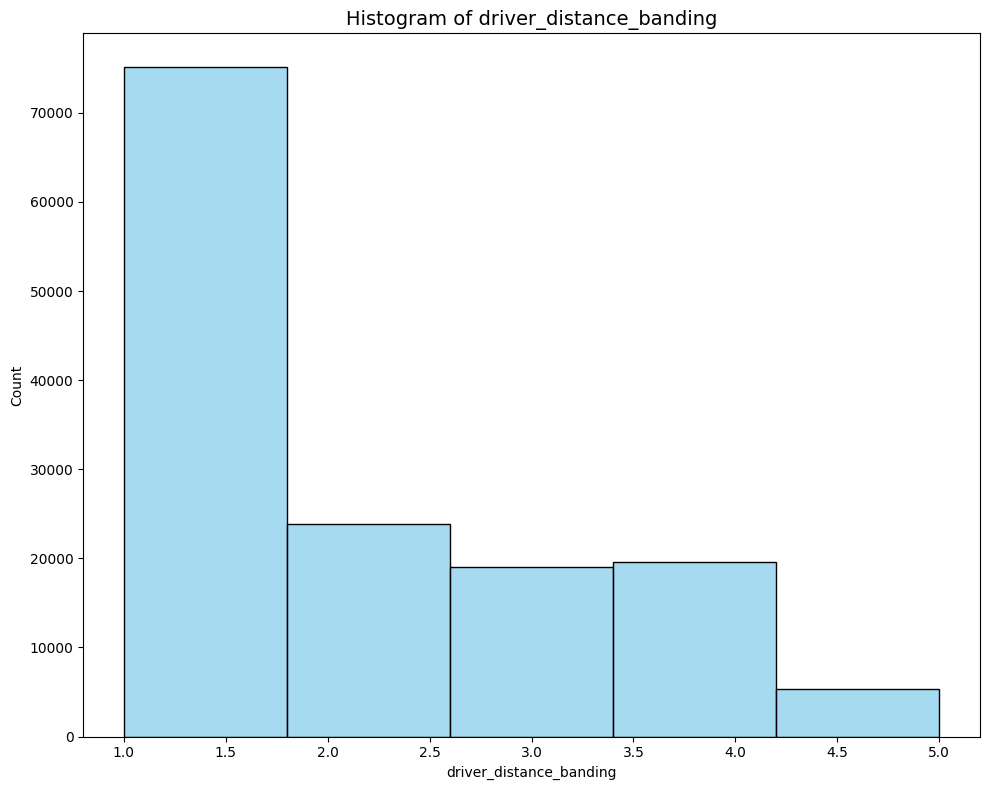

In [25]:
#chart loop
looping_col(histogram, df, chart=True)

In [ ]:
# sample output of the library desbordante for FDs
algo = algo = db.fd.algorithms.Default()
algo.load_data(table=('datasets/dft-road-casualty-statistics-vehicle-2024.csv', ',', True))
algo.execute()
print('FDs:')
for fd in algo.get_fds():
    print(fd)